# Optimise TGSD

In [4]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize, LinearConstraint, Bounds, SR1
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])
from matplotlib.animation import FuncAnimation, HTMLWriter

In [5]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df)

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86"
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04"
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41"
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73"
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48"
36,VF0518a3,-637,4876,166.88,16,3.1,21,25,22,16,7,2,0.9,0.8,"4,917.43"
35,VF0517a,-1268,5048,125.16,12,9.8,14,17,20,17,10,4,2.1,1.8,"5,204.82"
34,VF0516a3,-2101,5517,93.87,9,4.1,15,19,19,19,12,4,2.6,2.8,"5,903.52"
33,VF0514a3,-2250,5771,62.58,6,0.1,9,13,19,21,14,7,4.6,5.6,"6,194.11"
32,VF0513a,-2272,5925,62.58,6,4.2,9,17,19,17,11,8,5.5,4.2,"6,345.68"


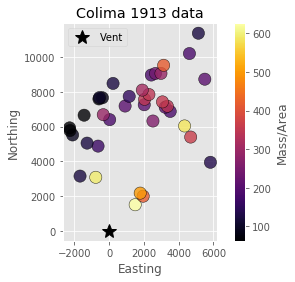

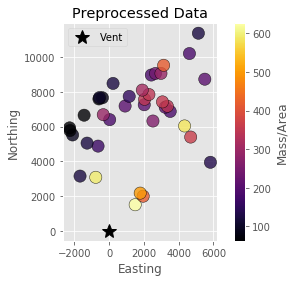

In [6]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

# obs_df = obs_df.drop([16, 18, 17])
#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [7]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2
7,2.5,"1,652.5","[2,3)",2,0.0474595,3
8,3.5,"1,862","[3,4)",3,0.0224962,4


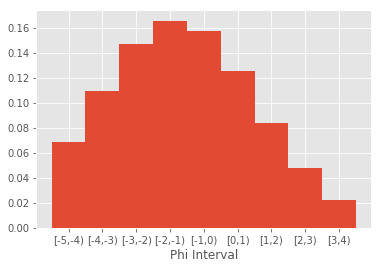

In [8]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

[0.05231643 0.16945065 0.20390996 0.20809308 0.19893822 0.12429353
 0.02893896 0.00704844 0.00701073]
[-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]


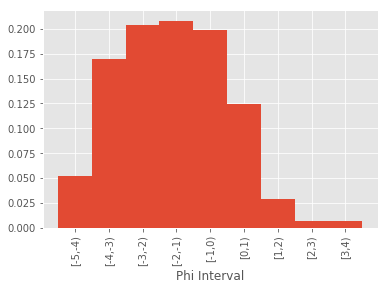

[{'lower': -5, 'upper': -4.0, 'interval': '[-5,-4)', 'centroid': -4.5, 'density': 1024.0, 'probability': 0.052316431318540024}, {'lower': -4.0, 'upper': -3.0, 'interval': '[-4,-3)', 'centroid': -3.5, 'density': 1024.0, 'probability': 0.1694506511837887}, {'lower': -3.0, 'upper': -2.0, 'interval': '[-3,-2)', 'centroid': -2.5, 'density': 1024.0, 'probability': 0.20390996005463202}, {'lower': -2.0, 'upper': -1.0, 'interval': '[-2,-1)', 'centroid': -1.5, 'density': 1024.0, 'probability': 0.2080930801364657}, {'lower': -1.0, 'upper': 0.0, 'interval': '[-1,0)', 'centroid': -0.5, 'density': 1024.0, 'probability': 0.19893821897376404}, {'lower': 0.0, 'upper': 1.0, 'interval': '[0,1)', 'centroid': 0.5, 'density': 1233.5, 'probability': 0.12429352702169855}, {'lower': 1.0, 'upper': 2.0, 'interval': '[1,2)', 'centroid': 1.5, 'density': 1443.0, 'probability': 0.028938961877603735}, {'lower': 2.0, 'upper': 3.0, 'interval': '[2,3)', 'centroid': 2.5, 'density': 1652.5, 'probability': 0.00704844304499

In [9]:
tgsd = get_tgsd(obs_df, phi_steps)
print(tgsd)
print(x)
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, tgsd, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

for i, phi in enumerate(phi_steps):
    phi["probability"] = tgsd[i]
print(phi_steps)

In [10]:
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

grid = obs_df[["Easting", "Northing"]]
forward_df = gaussian_stack_forward(
    grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
    config["PLUME_HEIGHT"], 2500, phi_steps, (config["ALPHA"],config["BETA"]), 
    config["ERUPTION_MASS"], 
    (u, v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
    config["FALL_TIME_THRESHOLD"]
)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values

display(forward_df.head())

,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,10.2913,29.5685,27.288,18.924,10.9616,2.84099,0.123803,0.001825,7.10812e-06,"1,678.84","2,124.86",2.68271
1,1997,1957,8.3142,27.1464,27.2807,20.2572,12.8676,3.91805,0.212099,0.00365928,1.57598e-05,"1,462.8","2,796.04",3.50624
2,2173,1787,8.22952,27.0446,27.2982,20.3207,12.9346,3.95335,0.215267,0.00373077,1.61147e-05,"1,504.98","2,813.41",3.00611
3,3082,-770,8.7488,27.7372,27.0418,19.5747,12.5223,4.11323,0.256923,0.00494637,2.29538e-05,428.027,"3,176.73",0.719966
4,3152,-1673,9.0285,28.313,27.0764,19.0615,12.0333,4.17711,0.303382,0.0066199,3.35645e-05,158.425,"3,568.48",1.26578


In [11]:
forward_df["phi_total"] = forward_df[labels].sum()

display(forward_df[labels].sum(axis=1))

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
10   100
11   100
12   100
13   100
14   100
15   100
16   100
17   100
18   100
19   100
20   100
21   100
22   100
23   100
24   100
25   100
26   100
27   100
28   100
29   100
30   100
31   100
32   100
33   100
34   100
35   100
36   100
37   100
dtype: float64

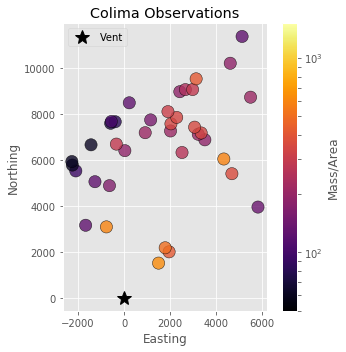

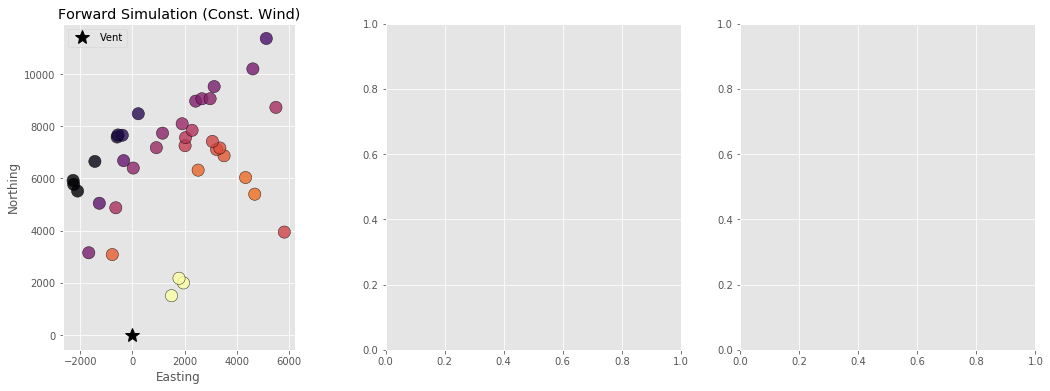

In [12]:

fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis.plot_sample(obs_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Colima Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[0])
# vis.plot_sample(t2_const_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
#             title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
# vis.plot_sample(t2_df, vent=(0,0), log=True, bounds=(50, 1500),
#             title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])
plt.show()



In [13]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

print(u, v)

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.06250 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,10.2913,29.5685,27.288,18.924,10.9616,2.84099,0.123803,0.001825,7.10812e-06,"1,678.84","2,124.86",2.68271
1,1997,1957,8.3142,27.1464,27.2807,20.2572,12.8676,3.91805,0.212099,0.00365928,1.57598e-05,"1,462.8","2,796.04",3.50624
2,2173,1787,8.22952,27.0446,27.2982,20.3207,12.9346,3.95335,0.215267,0.00373077,1.61147e-05,"1,504.98","2,813.41",3.00611
3,3082,-770,8.7488,27.7372,27.0418,19.5747,12.5223,4.11323,0.256923,0.00494637,2.29538e-05,428.027,"3,176.73",0.719966
4,3152,-1673,9.0285,28.313,27.0764,19.0615,12.0333,4.17711,0.303382,0.0066199,3.35645e-05,158.425,"3,568.48",1.26578


5.7357643635104605 8.191520442889917


In [17]:
k = 1, 2, 3

In [21]:
a, b, c = k

In [31]:
import numpy as np

In [32]:

a = np.array([1, 2, 3, 4])

b = [True, False, False, True]

a[b]



array([1, 4])